# Testing for a relationship between centrality and popularity

In [5]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pydot
import itertools

## Construct a graph using recent movies

In [3]:
df_roles = pd.read_pickle("../data/generated/preprocessed/roles.pkl")
df_roles.head(1)

,wiki_id,fb_movie_id,release,character_name,actor_age,fb_char_id,fb_actor_id,release_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,42.0,/m/0bgchxw,/m/03wcfv7,2001


In [7]:
edges = []

recent_roles = df_roles.loc[df_roles.release_year >= 2005].dropna(subset=['fb_actor_id'])

for movie_fbid, df_actor_movie in recent_roles.groupby('fb_movie_id'):
	# NOTE : we need to sort the edges, because we only store i -> j, but want an undirected graph
	# NOTE : we need to use unique(), because some actors play multiple characters in the same movie
	# e.g. df_actors.query('fb_movie_id == "/m/011xrr"')
	edges += [ (*sorted((actor1_fbid, actor2_fbid)), movie_fbid )
		for actor1_fbid, actor2_fbid 
              in itertools.combinations(df_actor_movie.fb_actor_id.unique(), r=2) ]

df_edges = pd.DataFrame(edges, columns=['actor1_fbid', 'actor2_fbid', 'movie_fbid'])

# sanity check that we indeed have ordered edges
assert (df_edges['actor1_fbid'] < df_edges['actor2_fbid']).all()
df_edges

,actor1_fbid,actor2_fbid,movie_fbid
0,/m/01515w,/m/01pkhw,/m/01_0f7
1,/m/01515w,/m/0ch1tl5,/m/01_0f7
2,/m/01515w,/m/0523xrr,/m/01_0f7
3,/m/01515w,/m/07lf49,/m/01_0f7
4,/m/01515w,/m/03jj93,/m/01_0f7
...,...,...,...
706897,/m/0c33pl,/m/0cp4b5,/m/0n4zpt9
706898,/m/05tb_b,/m/0cp4b5,/m/0n4zpt9
706899,/m/07p6t8,/m/0c33pl,/m/0n4zpt9
706900,/m/05tb_b,/m/07p6t8,/m/0n4zpt9


In [8]:
df_edges_grouped = (df_edges
	.groupby(['actor1_fbid', 'actor2_fbid'])
	[['movie_fbid']]
	.count()
	.reset_index()
	.sort_values('movie_fbid', ascending=False)  # movie_fbid count is the edge weight !!
)
df_edges_grouped.rename(columns={'movie_fbid': 'movie_count'}, inplace=True)
df_edges_grouped.head(10)

,actor1_fbid,actor2_fbid,movie_count
175796,/m/02qnyr7,/m/071wvh,42
189813,/m/02rzmzk,/m/071wvh,38
304750,/m/047s_cr,/m/071wvh,31
425539,/m/071wvh,/m/09tqx3,29
178194,/m/02qvhbb,/m/071wvh,28
238573,/m/03chx58,/m/071wvh,27
175740,/m/02qnyr7,/m/02rzmzk,24
238737,/m/03chxc3,/m/071wvh,23
174276,/m/02ql_ms,/m/071wvh,21
425597,/m/071wvh,/m/0fr7nt,19


In [9]:
df_actors = pd.read_pickle("../data/generated/preprocessed/actors.pkl")
df_actors = df_actors.loc[df_actors.actor_name.notna()]
actor_graph = nx.from_pandas_edgelist(df_edges_grouped, source='actor1_fbid', target='actor2_fbid', edge_attr=['movie_count'])
actor_graph = actor_graph.subgraph(df_actors.fb_actor_id).copy()

In [10]:
# a mapping from freebaseid to actor names
fbid2name = dict((row.fb_actor_id, row.actor_name) for _, row in df_actors.iterrows())
fbid2name_newline = dict((row.fb_actor_id, row.actor_name.replace(' ', '\n')) for _, row in df_actors.iterrows())  # for displaying graphs

actor_graph_names = nx.relabel_nodes(actor_graph, fbid2name)

## Selecting the largest connected componnent

In [12]:
# create a list of connected components
actor_graph_comps = [actor_graph.subgraph(c).copy() for c in nx.connected_components(actor_graph)]

In [14]:
actor_subgraph = max(actor_graph_comps, key=lambda G: G.number_of_nodes())
print(actor_subgraph)

Graph with 49481 nodes and 653771 edges


In [16]:
actor_subgraph_names = nx.relabel_nodes(actor_subgraph, fbid2name_newline)

## Computing centrality

In [17]:
degree_centrality = nx.degree_centrality(actor_subgraph)

In [18]:
eigenvector_centrality = nx.eigenvector_centrality(actor_subgraph)

In [22]:
betweenness_centrality = nx.betweenness_centrality(actor_subgraph, k=100)

In [23]:
df_centrality = pd.DataFrame(degree_centrality.items(), columns=['fb_actor_id', 'degree_centrality'])
df_centrality = df_centrality.merge(pd.DataFrame(eigenvector_centrality.items(), columns=['fb_actor_id', 'eigenvector_centrality']), on='fb_actor_id', how='left')
df_centrality = df_centrality.merge(pd.DataFrame(betweenness_centrality.items(), columns=['fb_actor_id', 'betweenness_centrality']), on='fb_actor_id', how='left')
df_centrality['actor_name'] = df_centrality.fb_actor_id.map(lambda i: fbid2name[i])

### Who are the top actors ?

In [24]:
df_centrality.sort_values('degree_centrality', ascending=False)[['degree_centrality', 'actor_name', 'fb_actor_id']].head(5)

,degree_centrality,actor_name,fb_actor_id
70,0.011601,Anupam Kher,/m/0292l3
744,0.010853,Jane Lynch,/m/07m77x
748,0.010287,Samuel L. Jackson,/m/0f5xn
710,0.009903,David Koechner,/m/059j1m
202,0.009863,Justin Long,/m/07cjqy


In [25]:
df_centrality.sort_values('eigenvector_centrality', ascending=False)[['eigenvector_centrality', 'actor_name']].head(5)

,eigenvector_centrality,actor_name
1150,0.095907,David Strathairn
6434,0.095699,Nicole Kidman
4889,0.095603,Clive Owen
6102,0.094613,Parker Posey
4467,0.094151,Rodrigo Santoro


In [26]:
df_centrality.sort_values('betweenness_centrality', ascending=False)[['betweenness_centrality', 'actor_name']].head(5)

,betweenness_centrality,actor_name
70,0.016499,Anupam Kher
3071,0.013688,Ha Jeong-woo
1032,0.013653,Stellan Skarsgård
867,0.013211,Doug Jones
5248,0.012593,Karel Roden


## Popularity through wikipedia pageviews

In [32]:
df_actors.index = df_actors.fb_actor_id

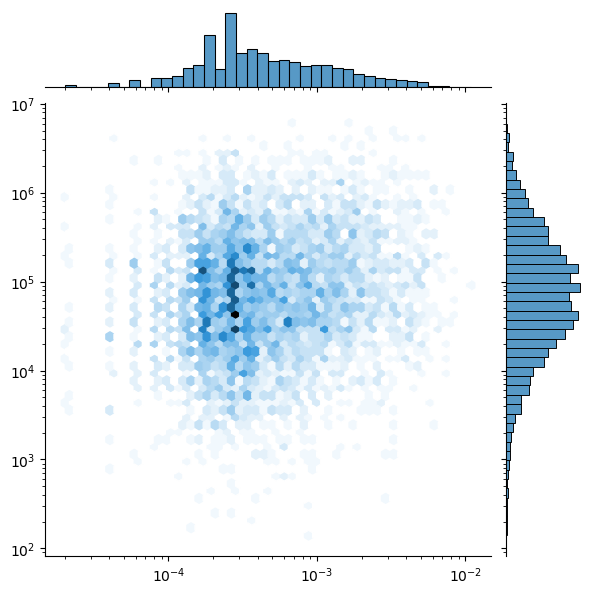

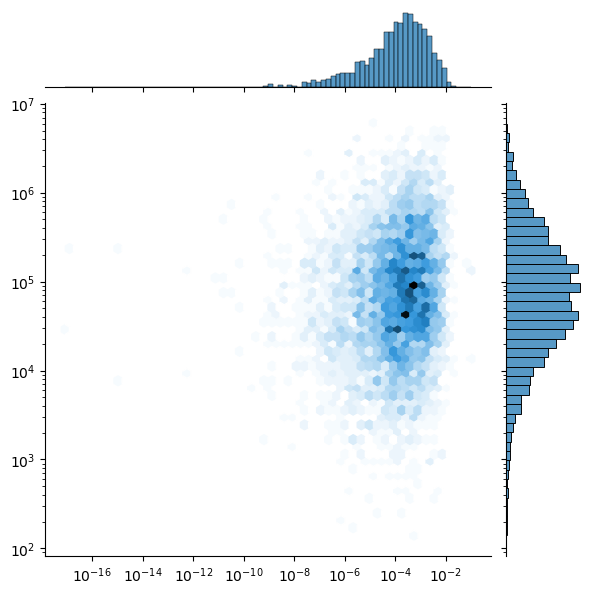

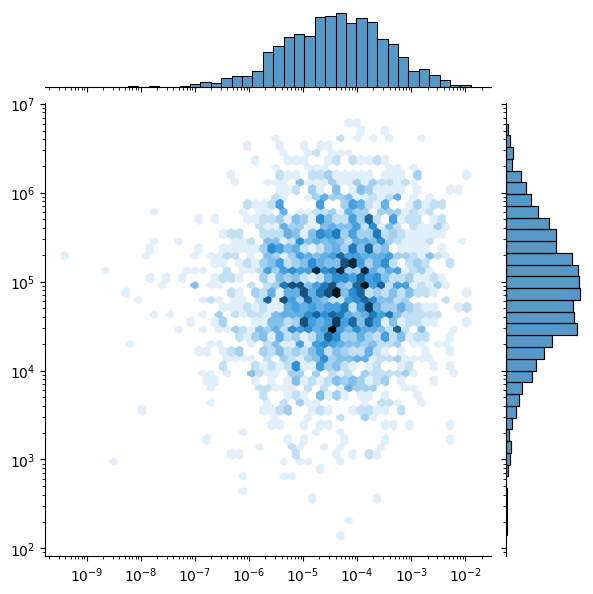

In [43]:
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    centrality = [c[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    pageviews = [df_actors.pageviews[node] for node in actor_subgraph.nodes() if not pd.isna(df_actors.pageviews[node]) and c[node] > 0]
    sns.jointplot(x=centrality, y=pageviews, kind="hex", xscale="log", yscale="log")

### Get more pageviews (Not actually necessary)

In [42]:
from mwviews.api import PageviewsClient
from collections import defaultdict

p = PageviewsClient(user_agent="<TeamLovelace@EPFL-CS401-2022> Analysis of actors")

def get_pageviews(names, langs):
    counts = {}
    actors = {}
    for lang in langs:
        actors[lang] = set()
        counts[lang] = defaultdict(lambda: None)
        project = "{}.wikipedia".format(lang)
        time_series = p.article_views(project, names)
        for time in time_series.values():
            for actor, count in time.items():
                if not count is None:
                    if counts[lang][actor] is None:
                        actors[lang].add(actor)
                        counts[lang][actor] = count
                    else:
                        counts[lang][actor] = counts[lang][actor] + count
    actors_to_keep = set.intersection(*actors.values())
    total_counts = {}
    for actor in actors_to_keep:
        total_counts[actor] = 0
        for lang, count in counts.items():
            total_counts[actor] += total_counts[actor] + count[actor]
    return total_counts

In [43]:
actor_names = [name.replace('\n', '_') for name in actor_subgraph_names.nodes()]
english_pageviews = get_pageviews(actor_names, ["en"])
print(len(english_pageviews))
print(len(actor_subgraph_names.nodes()))

72
69


### Redo analysis with more pageviews

In [45]:
name2fbid = dict((row.actor_name, row.fb_actor_id) for _, row in df_actors.iterrows())

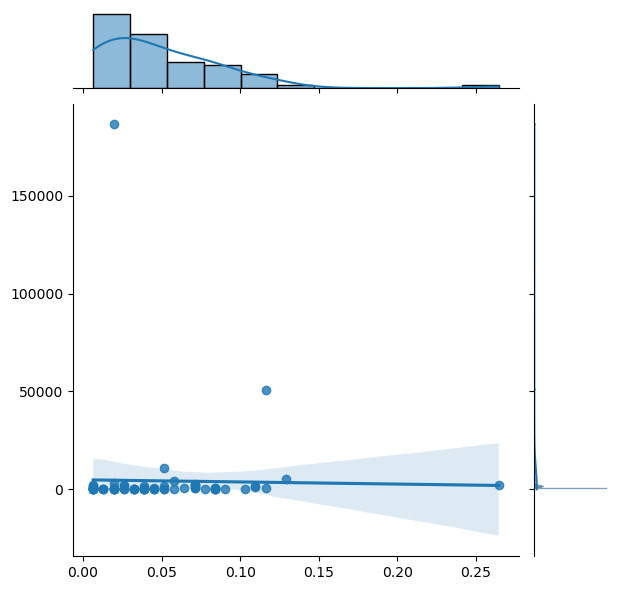

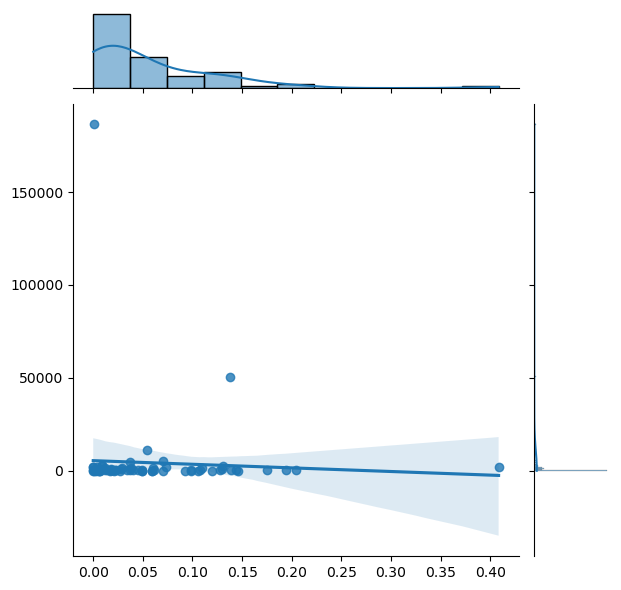

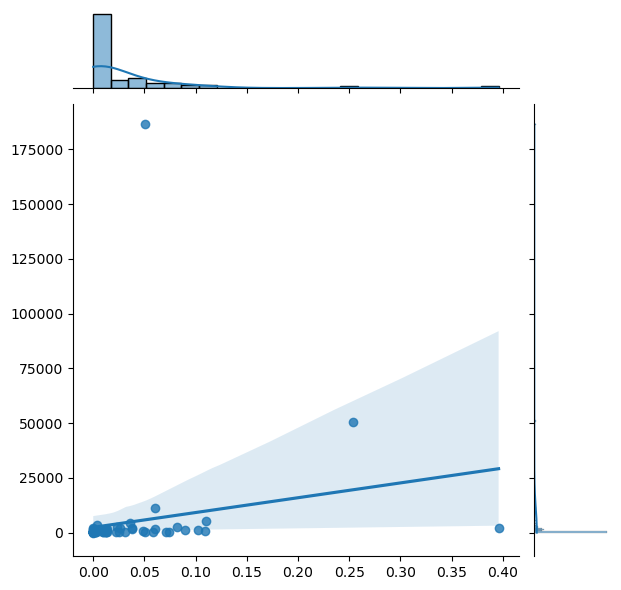

In [47]:
for c, t in zip([degree_centrality, eigenvector_centrality, betweenness_centrality], ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']):
    names_with_undescores = english_pageviews.keys()
    names_normal = [name.replace('_', ' ') for name in names_with_undescores]
    centrality = [c[name2fbid[node]] for node in names_normal]
    pageviews = [english_pageviews[node] for node in names_with_undescores]
    sns.jointplot(x=centrality, y=pageviews, kind="reg")

## Preliminary conclusions

In the above graph, nodes are sized according to eigenvalue centrality and are colored according to (Louvain) community, and edges are colored according to the movie.

Key observations :
- Communities often group actors which seem to have similar eigenvalue centrality, and have played in the same movies. For instance, the green community is well connected by majoritarily two movies, colored cyan and purple.
- Three communities stand out : red, gray and brown. With all three, they represent a large majority of the well ranked actors (according to eigenvalue centrality). These can be interpreted as the "popular" Belgian actors
- The five other communities are that of smaller actors. These might correspond to more "niche" communities.
- Smaller communities seem to rely on one or two entrypoint-actors. The pink community in the upper-right holds together solely through actor Senne Rouffaer. The green community has two entry-points : Johan Heldenberg, who provides a bridge with the (popular) brown community, and Matthias Schoenaerts, bridges with the more niche purple and blue communities.